In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import os
import io
import string
import re
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import string
import numpy as np
from collections import Counter
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [106]:
reviews = pd.read_csv('/content/Restaurant reviews.csv')
reviews.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0


In [107]:
rest_name_info = pd.read_csv("/content/Restaurant names and Metadata.csv")

rest_name_info.head()

,Name,Links,Cost,Collections,Cuisines,Timings
0,Beyond Flavours,https://www.zomato.com/hyderabad/beyond-flavou...,800,"Food Hygiene Rated Restaurants in Hyderabad, C...","Chinese, Continental, Kebab, European, South I...","12noon to 3:30pm, 6:30pm to 11:30pm (Mon-Sun)"
1,Paradise,https://www.zomato.com/hyderabad/paradise-gach...,800,Hyderabad's Hottest,"Biryani, North Indian, Chinese",11 AM to 11 PM
2,Flechazo,https://www.zomato.com/hyderabad/flechazo-gach...,"1,300","Great Buffets, Hyderabad's Hottest","Asian, Mediterranean, North Indian, Desserts","11:30 AM to 4:30 PM, 6:30 PM to 11 PM"
3,Shah Ghouse Hotel & Restaurant,https://www.zomato.com/hyderabad/shah-ghouse-h...,800,Late Night Restaurants,"Biryani, North Indian, Chinese, Seafood, Bever...",12 Noon to 2 AM
4,Over The Moon Brew Company,https://www.zomato.com/hyderabad/over-the-moon...,"1,200","Best Bars & Pubs, Food Hygiene Rated Restauran...","Asian, Continental, North Indian, Chinese, Med...","12noon to 11pm (Mon, Tue, Wed, Thu, Sun), 12no..."


In [108]:
reviews["Metadata"] = reviews["Metadata"].astype("str")

In [109]:
# Split Metadata Column in No_of_Reviews and No_of_Followers Column

reviews[['No_of_Reviews','No_of_Followers']] = reviews["Metadata"].str.split("," , expand=True)

# Delete Metadata Column
del reviews["Metadata"]
reviews[:3]

,Restaurant,Reviewer,Review,Rating,Time,Pictures,No_of_Reviews,No_of_Followers
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,5/25/2019 15:54,0,1 Review,2 Followers
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,5/25/2019 14:20,0,3 Reviews,2 Followers
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,5/24/2019 22:54,0,2 Reviews,3 Followers


In [110]:
# Delete characters from No_of_Reviews and No_of_Followers Column and Make it a numeric data type

reviews['No_of_Reviews'] = pd.to_numeric(reviews['No_of_Reviews'].str.replace(r'\D+', ''))
reviews['No_of_Followers'] = pd.to_numeric(reviews['No_of_Followers'].str.replace(r'\D+', '')) 
reviews[:3]

,Restaurant,Reviewer,Review,Rating,Time,Pictures,No_of_Reviews,No_of_Followers
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,5/25/2019 15:54,0,1.0,2.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,5/25/2019 14:20,0,3.0,2.0
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,5/24/2019 22:54,0,2.0,3.0


In [111]:
# Replace null values with 0 and convert column to int data type
reviews["No_of_Followers"] = reviews["No_of_Followers"].replace(np.nan, 0)
reviews["No_of_Followers"] = reviews["No_of_Followers"].astype("int")


In [112]:
# Top 10 Reviewed Restaurants

trer = reviews.groupby("Restaurant")["No_of_Reviews"].agg("sum").reset_index().sort_values(by = "No_of_Reviews", ascending = False)
trer_10 = trer[:10]
trer_10

,Restaurant,No_of_Reviews
55,Labonel,6628.0
68,Pista House,5429.0
20,Chinese Pavilion,5409.0
31,Dunkin' Donuts,5289.0
89,The Old Madras Baking Company,5127.0
22,Collage - Hyatt Hyderabad Gachibowli,4764.0
19,Cascade - Radisson Hyderabad Hitec City,4444.0
44,Hyderabadi Daawat,4412.0
33,Faasos,4392.0
30,Driven Cafe,4378.0


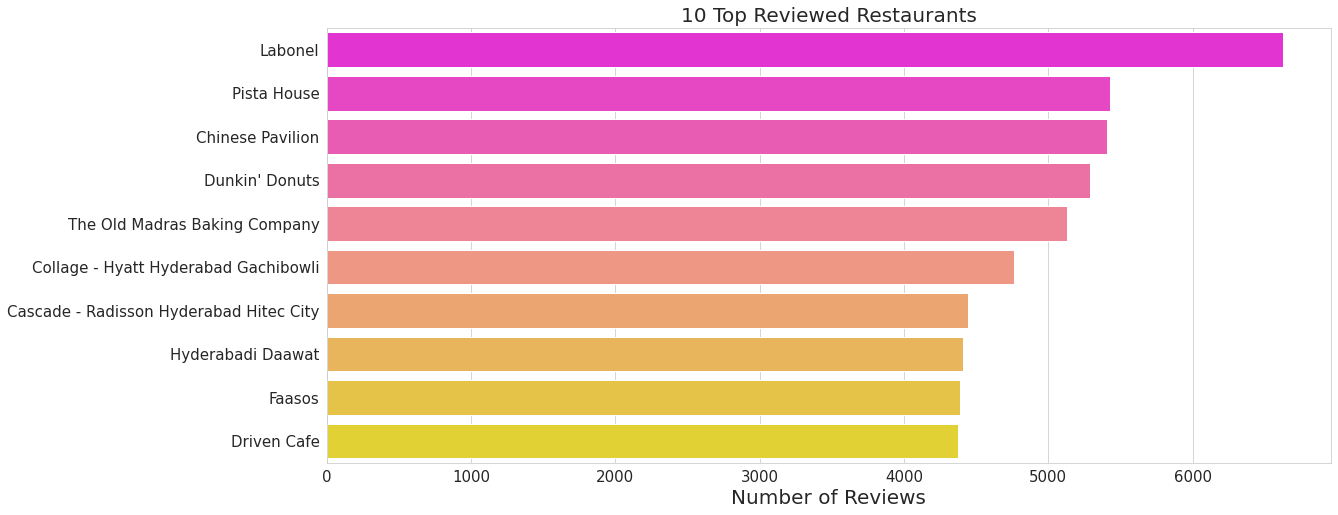

In [113]:
plt.figure(figsize = (18, 8))
sns.barplot(x = "No_of_Reviews", y = "Restaurant", data = trer_10, palette = "spring")
plt.title("10 Top Reviewed Restaurants", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Number of Reviews", size = 20)
plt.ylabel(None)
plt.savefig("10_Top_Reviewed_Restaurants.png")
plt.show()

In [114]:
tfr = reviews.groupby("Restaurant")["No_of_Followers"].agg("sum").reset_index().sort_values(by = "No_of_Followers", ascending = False)
tfr_10 = tfr[:10]
tfr_10

,Restaurant,No_of_Followers
68,Pista House,51068
52,Komatose - Holiday Inn Express & Suites,46229
44,Hyderabadi Daawat,45375
90,The Tilt Bar Republic,42126
31,Dunkin' Donuts,37667
20,Chinese Pavilion,35426
33,Faasos,34640
80,T Grill,32222
19,Cascade - Radisson Hyderabad Hitec City,31644
13,Barbeque Nation,30866


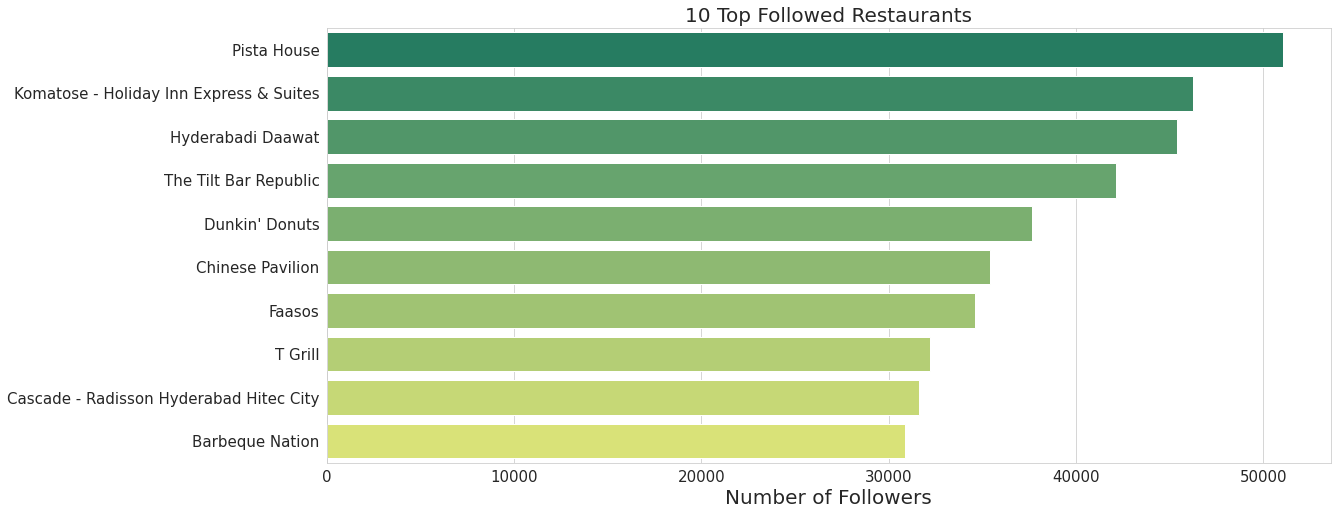

In [115]:
plt.figure(figsize = (18, 8))
sns.barplot(x = "No_of_Followers", y = "Restaurant", data = tfr_10, palette = "summer")
plt.title("10 Top Followed Restaurants", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Number of Followers", size = 20)
plt.ylabel(None)
plt.savefig("10_Top_Followed_Restaurants.png")
plt.show()

In [116]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [117]:
STOPWORDS = set(stopwordlist)

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

reviews['Review'] =reviews['Review'].apply(lambda text: cleaning_stopwords(text))
reviews['Review'].head()

0    The ambience good, food quite good . Saturday ...
1    Ambience good pleasant evening. Service prompt...
2    A must try.. great food great ambience. Thnx s...
3    Soumen das Arun great guy. Only behavior since...
4    Food good.we ordered Kodi drumsticks basket mu...
Name: Review, dtype: object

In [118]:
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

reviews['Review'] = reviews['Review'].apply(lambda x: cleaning_punctuations(x))
reviews['Review'].tail()

9995    Madhumathi Mahajan Well start nice courteous s...
9996    This place never disappointed us The food cour...
9997    Bad rating mainly Chicken Bone found Veg food ...
9998    I personally love prefer Chinese Food Had coup...
9999    Checked try delicious chinese food here seen n...
Name: Review, dtype: object

In [119]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

reviews['Review'] = reviews['Review'].apply(lambda x: cleaning_repeating_char(x))
reviews['Review'].tail()

9995    Madhumathi Mahajan Well start nice courteous s...
9996    This place never disappointed us The food cour...
9997    Bad rating mainly Chicken Bone found Veg food ...
9998    I personally love prefer Chinese Food Had coup...
9999    Checked try delicious chinese food here seen n...
Name: Review, dtype: object

In [120]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

reviews['Review'] = reviews['Review'].apply(lambda x: cleaning_numbers(x))
reviews['Review'].tail()

9995    Madhumathi Mahajan Well start nice courteous s...
9996    This place never disappointed us The food cour...
9997    Bad rating mainly Chicken Bone found Veg food ...
9998    I personally love prefer Chinese Food Had coup...
9999    Checked try delicious chinese food here seen n...
Name: Review, dtype: object

In [121]:
text = ' '.join(reviews["Review"])
words = text.split()

two_words = {' '.join(words):n for words,n in Counter(zip(words, words[1:])).items() if not  words[0][-1]==(',')}

In [123]:
two_words_df = pd.DataFrame(two_words.items(), columns=['Reviews Words', 'Frequency'])
two_words_df = two_words_df.sort_values(by = "Frequency", ascending = False)
two_words_20 = two_words_df[:20]
two_words_20

,Reviews Words,Frequency
2874,I ordered,559
554,The food,471
294,We ordered,391
1433,main course,387
207,really good,376
72,I would,372
1063,This place,353
2069,not good,349
459,good but,318
75,visit place,315


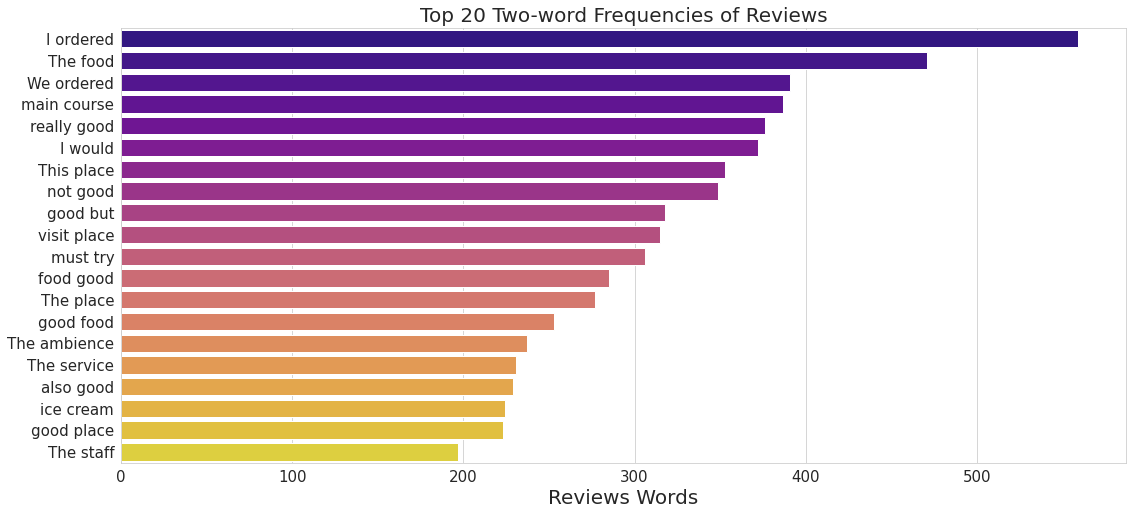

In [124]:
sns.set_style("whitegrid")
plt.figure(figsize = (18, 8))
sns.barplot(y = "Reviews Words", x = "Frequency", data = two_words_20, palette = "plasma")
plt.title("Top 20 Two-word Frequencies of Reviews", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Reviews Words", size = 20)
plt.ylabel(None)
plt.savefig("Top_20_Two-word_Frequencies_of_Reviews.png")
plt.show()

In [126]:
rest_name_info['Cuisines'] = rest_name_info['Cuisines'].apply(lambda text: cleaning_stopwords(text))
rest_name_info['Cuisines'].head()

0    Chinese Continental Kebab European South India...
1                         Biryani North Indian Chinese
2            Asian Mediterranean North Indian Desserts
3       Biryani North Indian Chinese Seafood Beverages
4    Asian Continental North Indian Chinese Mediter...
Name: Cuisines, dtype: object

In [127]:
rest_name_info['Cuisines'] = rest_name_info['Cuisines'].apply(lambda x: cleaning_punctuations(x))
rest_name_info['Cuisines'].head()

0    Chinese Continental Kebab European South India...
1                         Biryani North Indian Chinese
2            Asian Mediterranean North Indian Desserts
3       Biryani North Indian Chinese Seafood Beverages
4    Asian Continental North Indian Chinese Mediter...
Name: Cuisines, dtype: object

In [128]:
rest_name_info['Cuisines'] = rest_name_info['Cuisines'].apply(lambda x: cleaning_repeating_char(x))
rest_name_info['Cuisines'].head()

0    Chinese Continental Kebab European South India...
1                         Biryani North Indian Chinese
2            Asian Mediterranean North Indian Desserts
3       Biryani North Indian Chinese Seafood Beverages
4    Asian Continental North Indian Chinese Mediter...
Name: Cuisines, dtype: object

In [129]:
rest_name_info['Cuisines'] = rest_name_info['Cuisines'].apply(lambda x: cleaning_numbers(x))
rest_name_info['Cuisines'].head()

0    Chinese Continental Kebab European South India...
1                         Biryani North Indian Chinese
2            Asian Mediterranean North Indian Desserts
3       Biryani North Indian Chinese Seafood Beverages
4    Asian Continental North Indian Chinese Mediter...
Name: Cuisines, dtype: object

In [130]:
text = ' '.join(rest_name_info['Cuisines'])
words = text.split()

two_words = {' '.join(words):n for words,n in Counter(zip(words, words[1:])).items() if not  words[0][-1]==(',')}

In [131]:
two_words_dfc = pd.DataFrame(two_words.items(), columns=['Cuisine Words', 'Frequency'])
two_words_dfc = two_words_dfc.sort_values(by = "Frequency", ascending = False)
two_words_20c = two_words_dfc[:20]
two_words_20c

,Cuisine Words,Frequency
6,North Indian,61
9,Indian Chinese,27
42,Fast Food,15
4,South Indian,9
5,Indian North,9
33,Chinese North,8
24,Indian Continental,6
65,Italian North,6
8,Biryani North,6
28,Food North,6


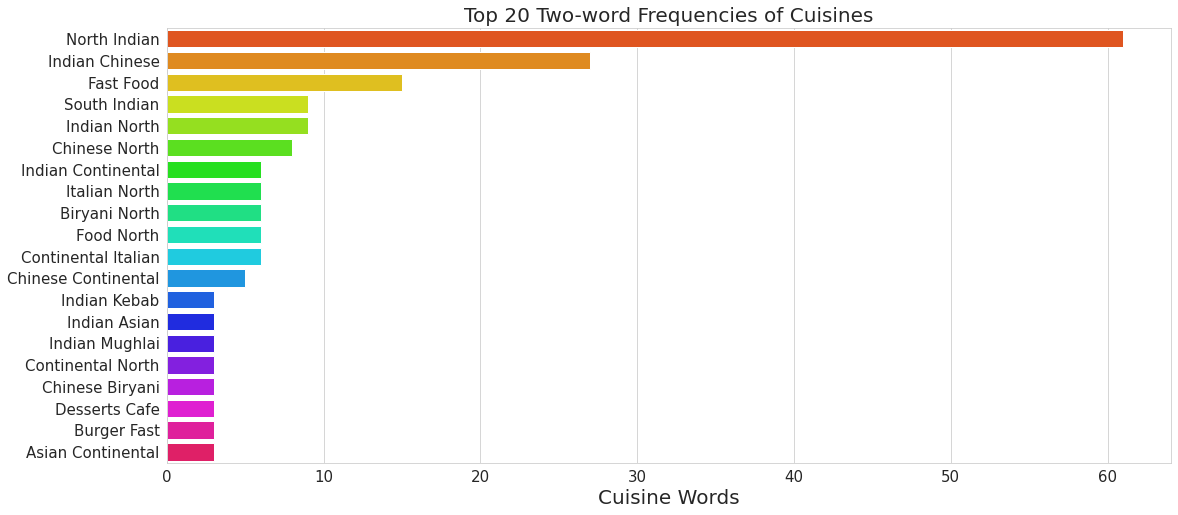

In [132]:
sns.set_style("whitegrid")
plt.figure(figsize = (18, 8))
sns.barplot(y = "Cuisine Words", x = "Frequency", data = two_words_20c, palette = "hsv")
plt.title("Top 20 Two-word Frequencies of Cuisines", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Cuisine Words", size = 20)
plt.ylabel(None)
plt.savefig("Top_20_Two-word_Frequencies_of_Cuisines.png")
plt.show()

In [133]:
reviews.shape

(10000, 8)

In [134]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Restaurant       10000 non-null  object 
 1   Reviewer         9962 non-null   object 
 2   Review           10000 non-null  object 
 3   Rating           9962 non-null   object 
 4   Time             9962 non-null   object 
 5   Pictures         10000 non-null  int64  
 6   No_of_Reviews    9962 non-null   float64
 7   No_of_Followers  10000 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 625.1+ KB


In [135]:
reviews =reviews.dropna()

In [136]:
reviews.shape

(9962, 8)

In [137]:
reviews_txt = reviews[['Review', 'Rating']]
reviews_txt.head()

,Review,Rating
0,The ambience good food quite good Saturday lu...,5
1,Ambience good pleasant evening Service prompt ...,5
2,A must try great food great ambience Thnx serv...,5
3,Soumen das Arun great guy Only behavior sincer...,5
4,Food goodwe ordered Kodi drumsticks basket mut...,5


In [138]:
reviews_txt['Rating'] = reviews_txt['Rating'].replace('Like', 5)
reviews_txt['Rating'] = reviews_txt['Rating'].astype('float')

In [139]:
reviews_txt['Rating'] = np.where(reviews_txt['Rating']<4, 0, 1) #0 for BAD rating and 1 for Good rating

In [140]:
reviews_txt.head()

,Review,Rating
0,The ambience good food quite good Saturday lu...,1
1,Ambience good pleasant evening Service prompt ...,1
2,A must try great food great ambience Thnx serv...,1
3,Soumen das Arun great guy Only behavior sincer...,1
4,Food goodwe ordered Kodi drumsticks basket mut...,1


In [143]:
reviews_txt['Rating'].value_counts()

1    6275
0    3687
Name: Rating, dtype: int64

In [144]:
reviews['Restaurant'].value_counts()

Aromas@11SIX              100
Mohammedia Shawarma       100
Domino's Pizza            100
13 Dhaba                  100
Karachi Cafe              100
                         ... 
Royal Spicy Restaurant    100
Tiki Shack                100
Paradise                  100
Arena Eleven               85
American Wild Wings        77
Name: Restaurant, Length: 100, dtype: int64

Data Visualization

In [145]:
reviews.columns

Index(['Restaurant', 'Reviewer', 'Review', 'Rating', 'Time', 'Pictures',
       'No_of_Reviews', 'No_of_Followers'],
      dtype='object')

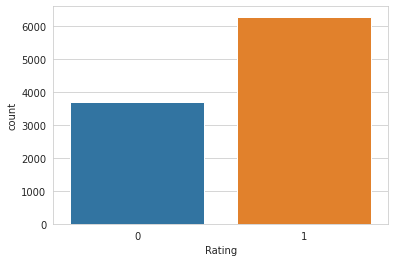

In [146]:
sns.countplot(reviews_txt['Rating']) #0 for bad and 1 for good

In [147]:
reviews=reviews[reviews['Rating']!='Like']

In [148]:
cuisine_list =rest_name_info .Cuisines.str.split(', ') #split the list into names
cuis_list = {} #create an empty list
for names in cuisine_list: # for any names in cuisine_list
    for name in names: # for any name in names
        if (name in cuis_list): #if this name is already present in the cuis_list
            cuis_list[name]+=1 # increase his value
        else:  # else
            cuis_list[name]=1 # Create his index in the list
cuis_df = pd.DataFrame(cuis_list.values(),index = cuis_list.keys(),columns = {'Counts of Restaurants'}) #Create a cuis dataframe
cuis_df.sort_values(by = 'Counts of Restaurants',ascending = False,inplace = True) #Sort the dataframe in ascending order
top_10_cuis = cuis_df[0:10] #Pick the 10 restaurant most nominated


Text(0.5, 1.0, 'Most popular cuisines at Restaurants in Hyderabad')

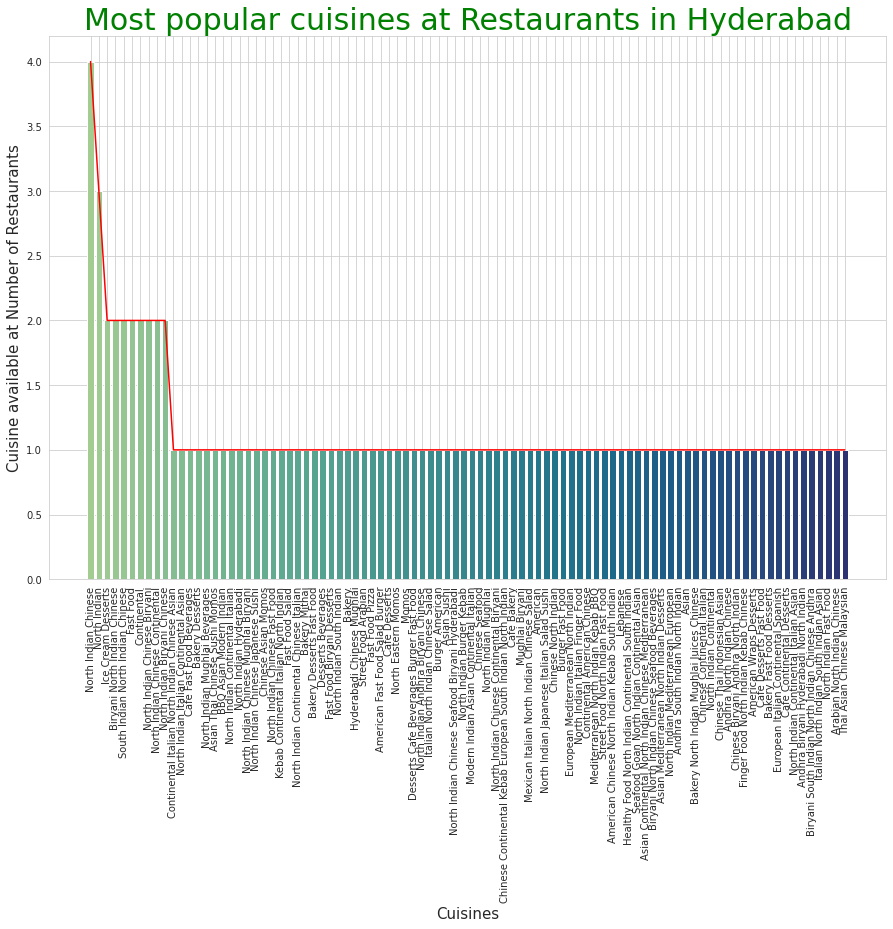

In [149]:
plt.figure(figsize=(15,10))
plt.plot(cuis_df.index,cuis_df['Counts of Restaurants'],color='red')
plt.bar(cuis_df.index,cuis_df['Counts of Restaurants'],color= sns.color_palette("crest",len (cuis_df.index)))
plt.xlabel('Cuisines',size=15)
plt.xticks(rotation=90)
plt.ylabel('Cuisine available at Number of Restaurants',size=15)
plt.title('Most popular cuisines at Restaurants in Hyderabad',size=30, color = 'green')

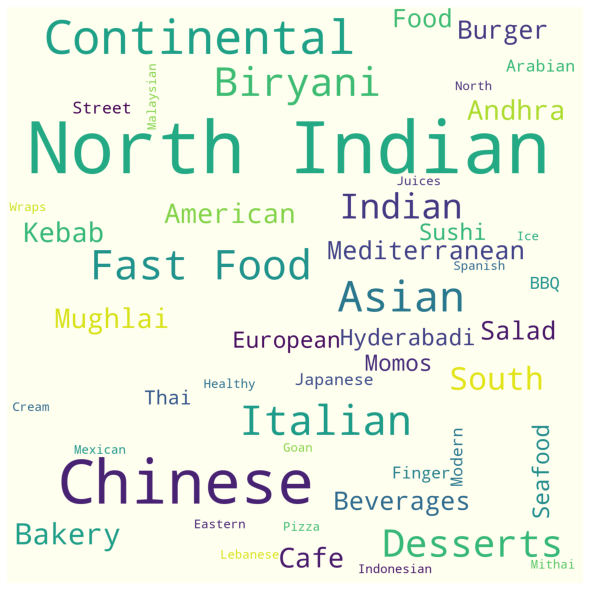

In [150]:
from wordcloud import WordCloud, STOPWORDS
words_list = cuis_list.keys()
strr = ' '
for i in words_list:
    strr=strr+i+' '
    
wordcloud = WordCloud(width = 1400, height = 1400, 
                background_color ='ivory',  
                min_font_size = 12).generate(strr) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

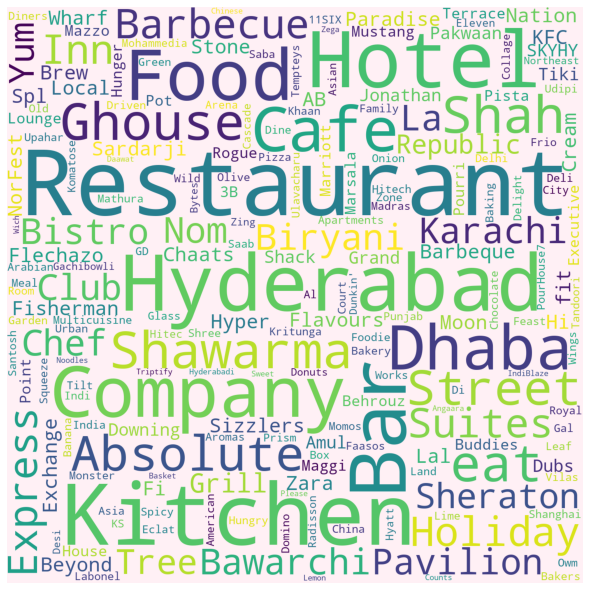

In [151]:
Rests = rest_name_info.Name.unique()
rest_string = ' '
for i in Rests:
   rest_string = rest_string+i+' '
    
wordcloud = WordCloud(width = 1400, height = 1400, 
                background_color ='lavenderblush',  
                min_font_size = 12).generate(rest_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [152]:
reviewer_list = reviews.groupby('Reviewer').apply(lambda x: x['Reviewer'].count()).reset_index(name='Review Count')
reviewer_list = reviewer_list.sort_values(by = 'Review Count',ascending=False)
top_reviewers = reviewer_list[:15]

Text(0, 0.5, 'N° of reviews')

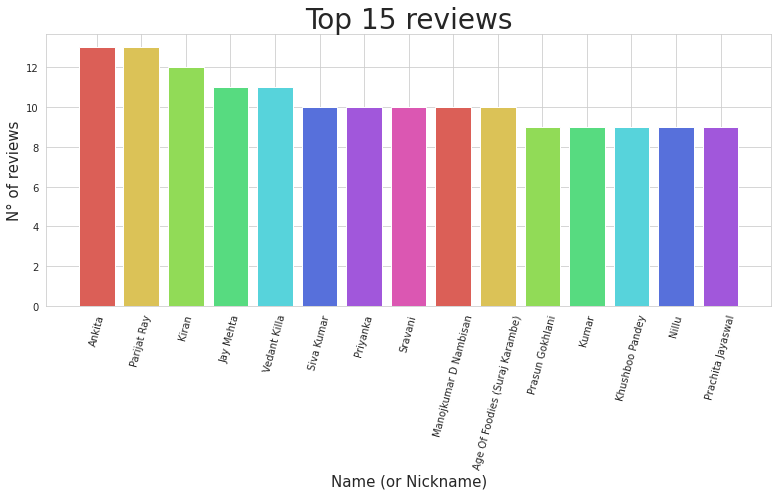

In [153]:
plt.figure(figsize=(13,5))
plt.bar(top_reviewers['Reviewer'], top_reviewers['Review Count'], color = sns.color_palette("hls", 8))
plt.xticks(rotation=75)
plt.title('Top 15 reviews',size=28)
plt.xlabel('Name (or Nickname)',size=15)
plt.ylabel('N° of reviews',size=15)

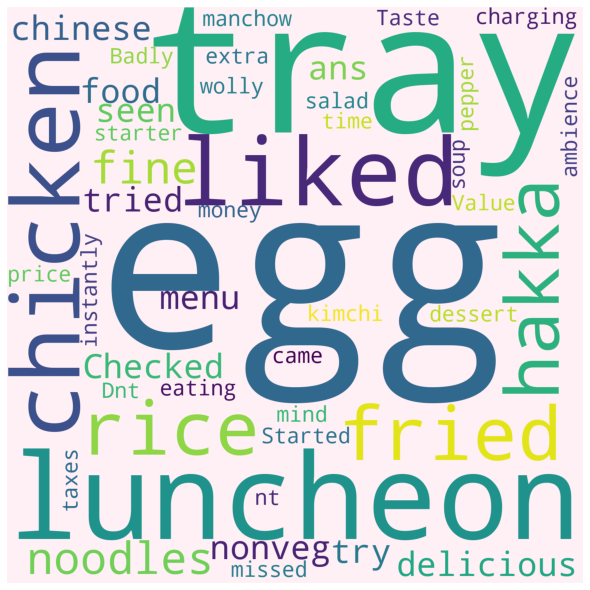

In [154]:
nlp = spacy.load('en')
reviews_feature = reviews['Review']
for review in reviews_feature:
    doc = nlp(review)
words = [token.text
         for token in doc
         if not token.is_stop and not token.is_punct]
rest_string = ' '
for i in words:
   rest_string = rest_string+i+' '
    
wordcloud = WordCloud(width = 1400, height = 1400, 
                background_color ='lavenderblush',  
                min_font_size = 12).generate(rest_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [155]:
import spacy

In [156]:
cleanup_re = re.compile('[^a-z]+')
def clean(sentence): 
  sentence = str(sentence)
  sentence = sentence.lower()
  sentence = cleanup_re.sub(' ', sentence).strip()
  return sentence
reviews_txt['Review'] = reviews_txt['Review'].apply(clean)

In [157]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [158]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [159]:
def preprocess(sentence):
  sentence = str(sentence)
  word_tokens = word_tokenize(sentence)
  stop_words = set(stopwords.words('english'))
  sentence = ' '.join([i for i in word_tokens if not i in stop_words])
  return sentence

reviews_txt['Review'] = reviews_txt['Review'].apply(preprocess)

In [160]:
reviews_txt.head()

,Review,Rating
0,ambience good food quite good saturday lunch c...,1
1,ambience good pleasant evening service prompt ...,1
2,must try great food great ambience thnx servic...,1
3,soumen das arun great guy behavior sincerety g...,1
4,food goodwe ordered kodi drumsticks basket mut...,1


In [161]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
def preprocess4(sentence):
  input_str=word_tokenize(sentence)
  lemmatized_output = ' '.join([lemma.lemmatize(w) for w in input_str])
  return lemmatized_output

reviews_txt['Review'] = reviews_txt['Review'].apply(preprocess4)

In [162]:
reviews_txt.head()

,Review,Rating
0,ambience good food quite good saturday lunch c...,1
1,ambience good pleasant evening service prompt ...,1
2,must try great food great ambience thnx servic...,1
3,soumen da arun great guy behavior sincerety go...,1
4,food goodwe ordered kodi drumstick basket mutt...,1


In [163]:
X = reviews_txt['Review']
y = reviews_txt['Rating']

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [165]:
X_train.shape, X_test.shape

((7969,), (1993,))

In [166]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)

#transform the train and test dataset
X_train_countvect = count_vect.transform(X_train)
X_test_countvect = count_vect.transform(X_test)

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)
 
 # ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(X_train)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(X_train)
xtrain_tfidf_ngram_char =  tfidf_vect_ngram_chars.transform(X_train)
xtest_tfidf_ngram_char =  tfidf_vect_ngram_chars.transform(X_test)

In [168]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return accuracy_score(predictions, y_test)

In [169]:
# Naive Bayes on Count Vectors
accuracy = train_model(MultinomialNB(), X_train_countvect, y_train, X_test_countvect)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_model(MultinomialNB(), xtrain_tfidf_ngram_char, y_train, xtest_tfidf_ngram_char)
print("NB, CharLevel Vectors: ", accuracy)

NB, Count Vectors:  0.865529352734571
NB, WordLevel TF-IDF:  0.8610135474159558
NB, N-Gram Vectors:  0.8088309081786252
NB, CharLevel Vectors:  0.845960863020572


In [170]:
# Logistic on Count Vectors
accuracy = train_model(LogisticRegression(), X_train_countvect, y_train, X_test_countvect)
print("Count Vectors: ", accuracy)

# Logistic on Word Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), xtrain_tfidf, y_train, xtest_tfidf)
print("WordLevel TF-IDF: ", accuracy)

# Logistic on Ngram Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("N-Gram Vectors: ", accuracy)

# Logistic on Character Level TF IDF Vectors
accuracy = train_model(LogisticRegression(), xtrain_tfidf_ngram_char, y_train, xtest_tfidf_ngram_char)
print("CharLevel Vectors: ", accuracy)

Count Vectors:  0.8580030105368791
WordLevel TF-IDF:  0.8720521826392373
N-Gram Vectors:  0.7917711991971902
CharLevel Vectors:  0.8715504264927245


In [171]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_model(SVC(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

NB, N-Gram Vectors:  0.7942799799297542


In [172]:
accuracy = train_model(RandomForestClassifier(n_estimators=250, random_state=100), X_train_countvect, y_train, X_test_countvect)
print("Count Vectors: ", accuracy)

# Random Forest on Word Level TF IDF Vectors
accuracy = train_model(RandomForestClassifier(), xtrain_tfidf, y_train, xtest_tfidf)
print("WordLevel TF-IDF: ", accuracy)

Count Vectors:  0.8700451580531862
WordLevel TF-IDF:  0.865529352734571


In [173]:
accuracy = train_model(BaggingClassifier(), X_train_countvect, y_train, X_test_countvect)
print("Count Vectors: ", accuracy)

# Bagging on Word Level TF IDF Vectors
accuracy = train_model(BaggingClassifier(), xtrain_tfidf, y_train, xtest_tfidf)
print("WordLevel TF-IDF: ", accuracy)

Count Vectors:  0.8223783241344707
WordLevel TF-IDF:  0.8359257400903161


In [174]:
import xgboost as xgb
accuracy = train_model(xgb.XGBClassifier(), X_train_countvect, y_train, X_test_countvect)
print("Count Vectors: ", accuracy)

# Boosting on Word Level TF IDF Vectors
accuracy = train_model(xgb.XGBClassifier(), xtrain_tfidf, y_train, xtest_tfidf)
print("WordLevel TF-IDF: ", accuracy)

Count Vectors:  0.8273958855995986
WordLevel TF-IDF:  0.8409433015554441


Further imporovemnts can be done using hyperparameter tuning

Classification using LSTM and tensorflow

In [175]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.layers import Dropout

In [176]:
#max words to be used
MAX_WORDS = 10000
#max length of the sequence
MAX_LEN = 50
#embedding dimension should be between 50 to 300
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print('number of unique tokens are: ', len(word_index))

number of unique tokens are:  16888


In [177]:
from keras.preprocessing.sequence import pad_sequences

In [178]:
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=MAX_LEN)
print('shape of data tensor is', X.shape)

shape of data tensor is (9962, 50)


In [179]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.2, random_state = 100)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7969, 50) (7969,)
(1993, 50) (1993,)


Building LSTM model

In [180]:
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS, output_dim= EMBEDDING_DIM, input_length=MAX_LEN))
model.add(LSTM(300, recurrent_dropout=0.1))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
history =model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               481200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
Total params: 1,481,501
Trainable params: 1,481,501
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
125/125 [==============================] - 74s 572ms/step - loss: 0.5025 - accuracy: 0.7606 - val_loss: 0.3402 - val_accuracy: 0.8575
Epoch 2/10
125/125 [==============================] - 71s 569ms/step - loss: 0.2784 - accura

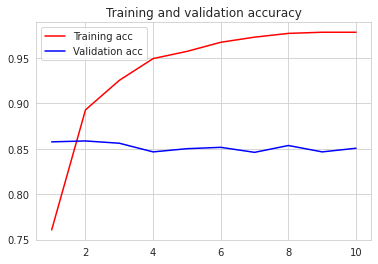

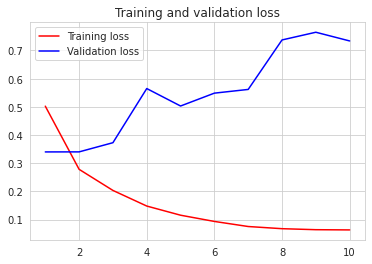

In [181]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()